In [1]:
# prerequisites
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

from scipy.stats import norm
from scipy import stats as sps 
import scipy
from scipy.spatial import distance
from scipy.stats import ks_2samp
from scipy.stats import multivariate_normal

import random
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

import torch

In [2]:
# data load
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr, x_te = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)
print(x_tr.shape, x_te.shape)

# network parameters
batch_size, n_epoch = 101, 5
n_hidden, z_dim = 256, 16

(60000, 784) (10000, 784)


In [3]:
x_f, y_f = [], [] 
rmv_idx = []

for i in range(10): 
    if i % 2 != 0: 
        
        # 1,3,5,7,9 
        idf_i = list(np.where(y_tr == i)[0]) 
        
        y_f.append([i]*len(idf_i))
        x_f.append(x_tr[idf_i]) 
        
            
        # remove elements by index list 
        rmv_idx += idf_i
             
x_tr = np.delete(x_tr, rmv_idx, axis=0) 
y_tr = np.delete(y_tr, rmv_idx, axis=0) 
        
x_f = np.array(x_f) 
y_f = np.array(y_f)

C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [4]:
print(x_tr.shape, x_te.shape)

(29492, 784) (10000, 784)


In [5]:
# encoder
x = Input(shape=(x_tr.shape[1:]))
x_encoded = Dense(n_hidden, activation='relu')(x)
x_encoded = Dense(n_hidden//2, activation='relu')(x_encoded)

mu = Dense(z_dim)(x_encoded)
log_var = Dense(z_dim)(x_encoded)

In [6]:
# sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps

z = Lambda(sampling, output_shape=(z_dim,))([mu, log_var])

In [7]:
# decoder
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr.shape[1], activation='sigmoid')

z_decoded = z_decoder1(z)
z_decoded = z_decoder2(z_decoded)
y = y_decoder(z_decoded)

In [8]:
# loss
reconstruction_loss = binary_crossentropy(x, y) * x_tr.shape[1]
kl_loss = 0.05 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
vae_loss = reconstruction_loss + kl_loss

# build model
vae = Model(x, y)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 16)           2064        dense_1[0][0]                    
______________________________________________________________________________________________

In [9]:
# train
vae.fit(x_tr,
       shuffle=True,
       epochs=n_epoch,
       batch_size=batch_size,
       verbose=1)

Epoch 1/5
292/292 [==============================] - 3s 7ms/step - loss: 215.6345
Epoch 2/5
292/292 [==============================] - 2s 7ms/step - loss: 134.0607
Epoch 3/5
292/292 [==============================] - 2s 7ms/step - loss: 118.0628
Epoch 4/5
292/292 [==============================] - 2s 7ms/step - loss: 110.0400
Epoch 5/5
292/292 [==============================] - 2s 7ms/step - loss: 104.8062


In [10]:
# build encoder
encoder = Model(x, mu)
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                2064      
Total params: 235,920
Trainable params: 235,920
Non-trainable params: 0
_________________________________________________________________


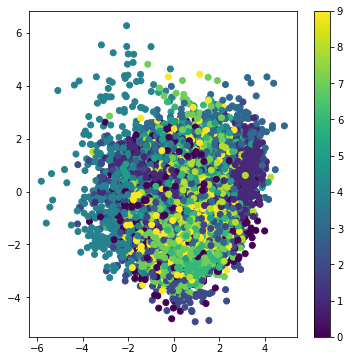

In [11]:
# Plot of the digit classes in the latent space
x_te_latent = encoder.predict(x_te, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te)
plt.colorbar()
plt.show()

In [12]:
# build decoder
decoder_input = Input(shape=(z_dim,))
_z_decoded = z_decoder1(decoder_input)
_z_decoded = z_decoder2(_z_decoded)
_y = y_decoder(_z_decoded)

generator = Model(decoder_input, _y)
generator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_4 (Dense)              multiple                  2176      
_________________________________________________________________
dense_5 (Dense)              multiple                  33024     
_________________________________________________________________
dense_6 (Dense)              multiple                  201488    
Total params: 236,688
Trainable params: 236,688
Non-trainable params: 0
_________________________________________________________________


# Few Shot Sampling

In [13]:
# https://github.com/Michedev/VAE_anomaly_detection/blob/0a9eb14b7df226e8195c77d145a0f586ecbb6d67/VAE.py#L7
def softplus(x):
    return np.log(1+np.exp(x))

from dictances import bhattacharyya, bhattacharyya_coefficient

In [14]:
# build model
vae_enc = Model(x, [mu, log_var])

vae_enc.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 16)           2064        dense_1[0][0]                    
____________________________________________________________________________________________

In [15]:
test_classes = []

for i in range(y_f.shape[0]):
    test_classes.append(y_f[i][0])
    
print(test_classes)

[1, 3, 5, 7, 9]


In [17]:
# Mahalanobis Distance
def mahalanobis(x=None, mean=None, cov=None):

    x_mu = x - mean
    inv_covmat = np.linalg.inv(cov)
    
    left = np.dot(x_mu, inv_covmat)
        
    mahal = np.dot(left, x_mu.T)
        
    return mahal

In [23]:
n_way = 3 # number of classes
n_shot = 5 # number of samples per class

n_trial = 0
n_true = 0
n_false = 0

n_test = 1200

g_train_images, g_train_gt_labels = np.load(str(n_way)+"-"+str(n_shot)+'.npz')["trainImage"],np.load(str(n_way)+"-"+str(n_shot)+'.npz')["trainLabel"]
g_test_images, g_test_gt_labels = np.load(str(n_way)+"-"+str(n_shot)+'.npz')["testImage"],np.load(str(n_way)+"-"+str(n_shot)+'.npz')["testLabel"]
g_ways = np.load(str(n_way)+"-"+str(n_shot)+'.npz')["ways"]

for ntest in tqdm(range(n_test)):
    #print("Test Classes: {}".format(test_classes))

    # Load test data
    test_images = g_test_images[ntest]
    test_gt_labels = g_test_gt_labels[ntest]


    train_images = g_train_images[ntest]
    train_gt_labels = g_train_gt_labels[ntest]
    
    ways = g_ways[ntest]

    train_mus = []
    train_vars = []

    for image in train_images:
        res = vae_enc.predict(image)
        mu_val = res[0][0]
        var_val = res[1][0]

        train_mus.append(mu_val)
        train_vars.append(K.exp(var_val))


    test_mus = []
    test_vars = []

    for image in test_images:
        res = vae_enc.predict(image)
        mu_val = res[0][0]
        var_val = res[1][0]

        test_mus.append(mu_val)
        test_vars.append(K.exp(var_val))

    ###########################
    # Averaging mean's and mu's for each class
    alpha = 1 / n_shot
    avg_train_mus = []
    avg_train_vars = []
    
    # average the mu and variance variables
    for i in range(0,len(train_mus) - 1, n_shot):
        
        
        avg_mu = np.mean(train_mus[i: i + n_shot], axis=0)
            
        class_mu = train_mus[i: i + n_shot]
        class_variance = train_vars[i: i + n_shot]        
                
        # sinif ici her bir mu variance al
        avg_var = [0.0] * z_dim
        for j in range(len(class_variance)):
            
            # For the 1st, 2nd, 3rd solutions            
            if n_shot != 1:
                avg_var += (( 1/n_shot * class_variance[j] ) + (1/n_shot * ((class_mu - avg_mu)**2)))
                
            # If there is only 1 sample, avg_var equals to that sample's var
            else:
                avg_var += class_variance[j]        
        
        # class oriented var
        avg_train_vars.append(avg_var)
        
        # class oriented mu
        avg_train_mus.append(avg_mu)
    
    test_pred_labels = []
    for i in range(len(test_mus)):
        # 1.st and 2.nd way
        #test_dist = scipy.stats.multivariate_normal(test_mus[i], test_vars[i])
        #test_elem = test_dist.rvs()
        
        # 3.rd way;
        test_dist = torch.distributions.Normal(torch.from_numpy(test_mus[i]), torch.from_numpy(np.sqrt(test_vars[i].numpy())))
        
        
        local_scores = []
        for j in range(len(avg_train_mus)):
            # 1.st way; MAHALANOBIS
            #scr = mahalanobis(test_elem, avg_train_mus[j], np.diag(avg_train_vars[j])) 
            
            # 2.nd way; PDF 
            #scr = scipy.stats.multivariate_normal(avg_train_mus[j], np.diag(avg_train_vars[j])).pdf(test_elem)    
            
            # 3.rd way; KL divergence
            train_dist = torch.distributions.Normal(torch.from_numpy(avg_train_mus[j]), torch.from_numpy(np.sqrt(np.array(avg_train_vars[j]))))
            scr = torch.distributions.kl_divergence(test_dist, train_dist).mean()
            
            local_scores.append(scr)

        # 1.st way, min of mahalanobis distance
        #pred_cls_idx = np.argmin(local_scores)
        
        # 2.nd way, maximum pdf
        #pred_cls_idx = np.argmax(local_scores)
    
        # 3.rd way, min of kl divergence
        pred_cls_idx = np.argmin(local_scores)
        
         
        test_pred_labels.append(ways[pred_cls_idx])


    for i in range(len(test_gt_labels)):
        if test_gt_labels[i] == test_pred_labels[i]:
            n_true += 1
        else:
            n_false += 1

        n_trial += 1

  0%|          | 0/1200 [00:00<?, ?it/s]

16 5 5
(16,)
Avg var shape:
(5, 16)
16 5 5
(16,)
Avg var shape:
(5, 16)
16 5 5
(16,)
Avg var shape:
(5, 16)


In [28]:
print("N_way: {} - K-shot: {}".format(n_way, n_shot))
print("Acc: {:.5f} in {} different trials".format(n_true/n_trial, n_test))

N_way: 3 - K-shot: 1
Acc: 0.48167 in 1200 different trials


#################
#################
# Save test data
#################
#################
n_way = 3 # number of classes
n_shot = 1 # number of samples per class

n_test = 1200

test_images = []
test_gt_labels = []


train_images = []
train_gt_labels = []

ways = []



for ntest in tqdm(range(n_test)):
    #print("Test Classes: {}".format(test_classes))

    local_test_images = []
    local_test_gt_labels = []


    local_train_images = []
    local_train_gt_labels = []

    class_selector = random.sample(range(1, len(test_classes)), n_way)
    local_ways = []

    for i in class_selector:
        local_ways.append(test_classes[i])

    #print("Selected Indices: {}".format(class_selector))
    #print("Selected Classes: {}".format(ways))


    for cls_idx in class_selector:

        class_label = test_classes[cls_idx]
        x_sample_idx = random.sample(range(0, x_f[cls_idx].shape[0]), n_shot+1)

        for c, idx in enumerate(x_sample_idx):

            x_sample = x_f[cls_idx][idx].reshape(-1,784)

            if c == len(x_sample_idx) - 1:
                local_test_images.append(x_sample)
                local_test_gt_labels.append(class_label)
            else:
                local_train_images.append(x_sample)
                local_train_gt_labels.append(class_label)

    # add local to general list
    test_images.append(local_test_images)
    test_gt_labels.append(local_test_gt_labels)
    
    train_images.append(local_train_images)
    train_gt_labels.append(local_train_gt_labels)
    ways.append(local_ways)

np.savez(str(n_way)+"-"+str(n_shot)+'.npz', trainImage=train_images, trainLabel=train_gt_labels, testImage=test_images, testLabel=test_gt_labels, ways=ways)

In [ ]:
# output of test images in terms of mu,sigma
test_0 = scipy.stats.multivariate_normal(test_mus[0], np.diag(test_vars[0]))
test_1 = scipy.stats.multivariate_normal(test_mus[1], np.diag(test_vars[1]))
test_2 = scipy.stats.multivariate_normal(test_mus[2], np.diag(test_vars[2]))

dist_0 = sps.multivariate_normal(avg_train_mus[0], np.diag(avg_train_vars[0]))
dist_1 = sps.multivariate_normal(avg_train_mus[1], np.diag(avg_train_vars[1]))
dist_2 = sps.multivariate_normal(avg_train_mus[2], np.diag(avg_train_vars[2]))

In [ ]:
test_sample = test_0.rvs(100)
test_sample = np.mean(test_sample, axis=0)
test_sample

In [ ]:
n_sample = 1

test_sample = test_1.rvs(10)
test_sample = np.mean(test_sample, axis=0)

score_0 = 0.0
for i in range(n_sample):
    score_0 += mahalanobis(test_sample[i], train_mus[0], np.diag(avg_train_vars[0]))
    
print(score_0/n_sample)

score_1 = 0.0
for i in range(n_sample):
    score_1 += mahalanobis(test_sample[i], train_mus[1], np.diag(avg_train_vars[1]))
    
print(score_1/n_sample)

score_2 = 0.0
for i in range(n_sample):
    score_2 += mahalanobis(test_sample[i], train_mus[2], np.diag(avg_train_vars[2]))
    
print(score_2/n_sample)

In [ ]:
eps = K.random_normal(shape=(100, z_dim), mean=0., stddev=1.0)

dist_a1 = train_mus[0] + K.exp(train_vars[0]) * eps
dist_b1 = train_mus[1] + K.exp(train_vars[1]) * eps
dist_c1 = train_mus[2] + K.exp(train_vars[2]) * eps


m_a1, std_a1 = np.mean(np.array(dist_a1)), np.std(np.array(dist_a1))
m_b1, std_b1 = np.mean(np.array(dist_b1)), np.std(np.array(dist_b1))
m_c1, std_c1 = np.mean(np.array(dist_c1)), np.std(np.array(dist_c1))


x_a1 = np.random.normal(m_a1, std_a1, 100)
x_b1 = np.random.normal(m_b1, std_b1, 100)
x_c1 = np.random.normal(m_c1, std_c1, 100)


#######################
multivariate_a1 = scipy.stats.multivariate_normal(train_mus[0], np.diag(np.exp(train_vars[0])))
multivariate_b1 = scipy.stats.multivariate_normal(train_mus[1], np.diag(np.exp(train_vars[1])))
multivariate_c1 = scipy.stats.multivariate_normal(train_mus[2], np.diag(np.exp(train_vars[2])))

multivariate_1 = scipy.stats.multivariate_normal(avg_train_mus[0], np.diag(np.exp(avg_train_vars[0])))
multivariate_2 = scipy.stats.multivariate_normal(avg_train_mus[1], np.diag(np.exp(avg_train_vars[1])))
multivariate_3 = scipy.stats.multivariate_normal(avg_train_mus[2], np.diag(np.exp(avg_train_vars[2])))

In [ ]:
ks_2samp(x_a1, x_a1)

In [ ]:
ks_2samp(x_a1, x_b1)

In [ ]:
ks_2samp(x_a1, x_c1)

In [ ]:
ks_2samp(x_b1, x_c1)

In [ ]:
sps.ks_2samp()